In [71]:
import numpy as np
import xarray as xr

import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

# Open SOS slow data

In [72]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone( sos_df, 'UTC', 'US/Mountain')

## Plot wind directions for case studies

In [73]:
def wind_chart(data):
    return alt.Chart(data).mark_line().encode(        
        alt.X('time:T'),
        alt.Y('value:Q'),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(height=150)
def vertical_lines_chart(data):
    return alt.Chart(
        data
    ).mark_rule(color='red', strokeDash=[4, 2]).encode(
        alt.X('time:T')
    )


sos_dir_df = sos_df_localtime[sos_df_localtime.variable.isin([
        'dir_3m_c', 'dir_10m_c', 'dir_20m_c'
    ])].set_index('time')

(
    (wind_chart(sos_dir_df.loc['20230409'].reset_index())   + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-09T15:00:00', '2023-04-09T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230418'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-04-18T15:00:00', '2023-04-18T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20221221'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2022-12-21T15:00:00', '2022-12-21T18:00:00']}))) 
    | (wind_chart(sos_dir_df.loc['20230304'].reset_index()) + vertical_lines_chart(pd.DataFrame({'time': ['2023-03-04T15:00:00', '2023-03-04T18:00:00']})))
)

alt.HConcatChart(...)

In [74]:
sos_dir_df.sort_index().loc['20230418 1900': '20230418 2200'].query("variable == 'dir_3m_c'").value.mean()

158.2565144130162

# Open SOS fast data

In [ ]:
apr18_df = fast_data_files_to_dataframe([
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_21.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_22.nc',
    # '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230418_23.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_01.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_02.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20230419_03.nc',
],  rotation='double')

apr18_df = utils.modify_df_timezone(apr18_df, pytz.UTC, "US/Mountain")

In [ ]:
src = apr18_df.set_index('time')[['u_10m_c', 'w_10m_c']]
src_fluc = src - src.groupby(pd.Grouper(freq='30min')).transform('mean')
plt.hist2d(src_fluc.u_10m_c, src_fluc.w_10m_c, bins=500, cmap='Reds')
plt.axhline(0)
plt.axvline(0)
plt.colorbar()
plt.xlim(-2,2); plt.ylim(-2,2)
plt.show()

# Spectra across two case study days - Apr 18 and Dec 21

## Apr 18

### u'w' cospectra - all ECs

In [ ]:
apr18_u_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
apr18_u_w_3m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
apr18_u_w_3m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
apr18_u_w_3m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

apr18_u_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
apr18_u_w_10m_d_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
apr18_u_w_10m_ue_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
apr18_u_w_10m_uw_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

apr18_u_w_5m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
apr18_u_w_15m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
apr18_u_w_20m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

In [ ]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log').title('tau (s)'),
)
def mrd_plot(data, title=''):
    return alt.layer(
        base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q')),
        base.mark_line().encode(alt.Y('mean(Co):Q')),
        data=data
    ).properties(width=200, height=200, title=title)

In [ ]:
(
    (
        mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(apr18_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(apr18_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(apr18_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(apr18_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(apr18_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

### Isotropic stress cospectra - tower c 3 and 10m

In [ ]:
apr18_u_u_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
apr18_v_v_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
apr18_w_w_3m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

apr18_u_u_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
apr18_v_v_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
apr18_w_w_10m_c_mrd_df = calculate_mrd_for_df(apr18_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

In [ ]:
((
    mrd_plot(apr18_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(apr18_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(apr18_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(apr18_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(apr18_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(apr18_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

## Dec 21

In [ ]:
dec21_df = fast_data_files_to_dataframe([
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_21.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_22.nc',
    '/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_20221221_23.nc',
],  rotation='double')
dec21_df = utils.modify_df_timezone(dec21_df, pytz.UTC, "US/Mountain")

### u'w' cospectra - all ECs

In [ ]:
dec21_u_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'w_3m_c', shift = 2000, parallelism=8)
dec21_u_w_3m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_d', 'w_3m_d', shift = 2000, parallelism=8)
dec21_u_w_3m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_ue', 'w_3m_ue', shift = 2000, parallelism=8)
dec21_u_w_3m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_uw', 'w_3m_uw', shift = 2000, parallelism=8)

dec21_u_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'w_10m_c', shift = 2000, parallelism=8)
dec21_u_w_10m_d_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_d', 'w_10m_d', shift = 2000, parallelism=8)
dec21_u_w_10m_ue_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_ue', 'w_10m_ue', shift = 2000, parallelism=8)
dec21_u_w_10m_uw_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_uw', 'w_10m_uw', shift = 2000, parallelism=8)

dec21_u_w_5m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_5m_c', 'w_5m_c', shift = 2000, parallelism=8)
dec21_u_w_15m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_15m_c', 'w_15m_c', shift = 2000, parallelism=8)
dec21_u_w_20m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_20m_c', 'w_20m_c', shift = 2000, parallelism=8)

In [ ]:
def mrd_plot(data, title='', color=None):
    base = alt.Chart().encode(
        alt.X('tau:Q').scale(type='log').title('tau (s)'),
    )
    if color:
        band = base.mark_errorband(extent='iqr', color=color).encode(alt.Y('Co:Q'))
        line = base.mark_line(color=color).encode(alt.Y('mean(Co):Q'))
    else:
        band = base.mark_errorband(extent='iqr').encode(alt.Y('Co:Q'))
        line = base.mark_line().encode(alt.Y('mean(Co):Q'))
    return alt.layer(
        band, line, data=data
    ).properties(width=200, height=200, title=title)

In [ ]:
(
    (
        mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") | mrd_plot(dec21_u_w_3m_d_mrd_df, "u'w', 3m-D") 
        | mrd_plot(dec21_u_w_3m_ue_mrd_df, "u'w', 3m-UE") | mrd_plot(dec21_u_w_3m_uw_mrd_df, "u'w', 3m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") | mrd_plot(dec21_u_w_10m_d_mrd_df, "u'w', 10m-D") 
        | mrd_plot(dec21_u_w_10m_ue_mrd_df, "u'w', 10m-UE") | mrd_plot(dec21_u_w_10m_uw_mrd_df, "u'w', 10m-UW")
    ).resolve_scale(y='shared') & (
        mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") |  mrd_plot(dec21_u_w_15m_c_mrd_df, "u'w', 15m-C") |  mrd_plot(dec21_u_w_20m_c_mrd_df, "u'w', 20m-C")
    ).resolve_scale(y='shared')
).resolve_scale(y='shared')

In [ ]:
(mrd_plot(dec21_u_w_3m_c_mrd_df, "u'w', 3m-C") + mrd_plot(apr18_u_w_3m_c_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_d_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_ue_mrd_df, "u'w', 3m-C", color='#ff7f0e') + mrd_plot(apr18_u_w_3m_uw_mrd_df, "u'w', 3m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_10m_c_mrd_df, "u'w', 10m-C") + mrd_plot(apr18_u_w_10m_c_mrd_df, "u'w', 10m-C", color='#ff7f0e')) |\
(mrd_plot(dec21_u_w_5m_c_mrd_df, "u'w', 5m-C") + mrd_plot(apr18_u_w_5m_c_mrd_df, "u'w', 5m-C", color='#ff7f0e'))

### Isotropic stress cospectra - tower c 3 and 10m

In [ ]:
dec21_u_u_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_3m_c', 'u_3m_c', shift = 2000, parallelism=8)
dec21_v_v_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_3m_c', 'v_3m_c', shift = 2000, parallelism=8)
dec21_w_w_3m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_3m_c', 'w_3m_c', shift = 2000, parallelism=8)

dec21_u_u_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'u_10m_c', 'u_10m_c', shift = 2000, parallelism=8)
dec21_v_v_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'v_10m_c', 'v_10m_c', shift = 2000, parallelism=8)
dec21_w_w_10m_c_mrd_df = calculate_mrd_for_df(dec21_df, 'w_10m_c', 'w_10m_c', shift = 2000, parallelism=8)

In [ ]:
((
    mrd_plot(dec21_u_u_3m_c_mrd_df, "u'u', 3m-C") | mrd_plot(dec21_v_v_3m_c_mrd_df, "v'v', 3m-C") 
).resolve_scale(y='shared') & (
    mrd_plot(dec21_u_u_10m_c_mrd_df, "u'u', 10-C") | mrd_plot(dec21_v_v_10m_c_mrd_df, "v'v', 3m-C")
).resolve_scale(y='shared')).resolve_scale(y='shared') | (
    mrd_plot(dec21_w_w_3m_c_mrd_df, "w'w', 3m-C") & mrd_plot(dec21_w_w_10m_c_mrd_df, "w'w', 10m-C")
).resolve_scale(y='shared')

# Spectra across two months of data

Open up all the nomrd files. Calculate a "median time" for joining with synoptic wind measurements

In [75]:
nomrd_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/mrd/NOmrds/")
nomrd_df['median_time'] = nomrd_df.start_time + 0.5*(nomrd_df.end_time - nomrd_df.start_time)
nomrd_df['median_time_rounded'] = nomrd_df.median_time.dt.round('30min')
nomrd_df

,tau,Co,std,iteration,start_time,end_time,covariance,loc,median_time,median_time_rounded
0,0.1,-0.002316,4.401546e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
1,0.2,-0.004666,4.751782e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
2,0.4,-0.007815,5.590110e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
3,0.8,-0.011504,6.878115e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
4,1.6,-0.011965,6.791920e-02,0,2022-12-21 14:00:00,2022-12-21 15:49:13.550,u_w_,3m_c,2022-12-21 14:54:36.775,2022-12-21 15:00:00
...,...,...,...,...,...,...,...,...,...,...
12,409.6,0.000337,1.142486e-03,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
13,819.2,0.001552,1.921631e-03,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
14,1638.4,0.000481,4.260532e-04,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00
15,3276.8,-0.000060,7.827031e-06,41,2023-04-30 16:08:20,2023-04-30 17:57:33.550,w_h2o_,10m_d,2023-04-30 17:02:56.775,2023-04-30 17:00:00


Remove the Dec 21 MRD

In [76]:
nomrd_df = nomrd_df[nomrd_df.start_time.dt.month != 12]

In [77]:
nomrd_df.start_time.dt.hour.min(), nomrd_df.start_time.dt.hour.max()

(8, 16)

Use doppler lidar data to identify along-valley/cross-valley synoptic flows

In [78]:
cross_valley_wind_times = pd.read_csv('cross_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='cross-valley'
)
cross_valley_wind_times.index = pd.to_datetime(cross_valley_wind_times.index)

along_valley_wind_times = pd.read_csv('along_valley_wind_times.csv').drop(columns='Unnamed: 0').rename(columns={'0':'time'}).set_index('time').assign(
    wind_dir='along-valley'
)
along_valley_wind_times.index = pd.to_datetime(along_valley_wind_times.index)

winds_ge10_times =      pd.read_csv('winds_ge10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='> 10')
winds_ge10_times.index = pd.to_datetime(winds_ge10_times.index)
winds_le10_times =      pd.read_csv('winds_le10_times.csv').drop(columns='Unnamed: 0').set_index('time').assign(wind_speed='<= 10')
winds_le10_times.index = pd.to_datetime(winds_le10_times.index)

Join the datasets

In [79]:
nomrd_df_synopticwinds = pd.concat([
    nomrd_df.set_index('median_time_rounded').join(cross_valley_wind_times, how='inner'),
    nomrd_df.set_index('median_time_rounded').join(along_valley_wind_times, how='inner')
])
nomrd_df_synopticwinds = nomrd_df_synopticwinds.join(pd.concat([ winds_le10_times, winds_ge10_times]), how='inner')

In [80]:
base = alt.Chart().encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Color('wind_dir:N'),
).properties(width=200, height=200, title = "u'w', 3m-c")

def layer_plot(data, title=''):
    return alt.layer(
        base.encode(alt.Y('Co:Q')).mark_errorband(extent='iqr'),
        base.encode(alt.Y('mean(Co):Q')).mark_line(),
        data = data
    ).facet(alt.Row('wind_speed')).properties(title=title)

In [81]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
src['date'] = src.start_time.dt.date.astype('str')
alt.Chart(
    src.query("loc == '3m_c'")
).mark_line(strokeWidth=1, point={'size': 10}).encode(
    alt.X('tau:Q').scale(type='log'),
    alt.Y('mean(Co):Q'),
    alt.Detail('date'),
    alt.Color('wind_dir:N'),
    alt.Facet('wind_speed'),
    tooltip = 'date'
).properties(width=200, height=200)

alt.Chart(...)

In [82]:
4/18, 3/8, 4/2, 3/6

(0.2222222222222222, 0.375, 2.0, 0.5)

In [83]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c")
    &\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c")
    &\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
    &\
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c")
    &\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

) 

alt.VConcatChart(...)

In [84]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") | layer_plot(src.query("loc == '3m_d'"), title="u'w' 3m_d") | layer_plot(src.query("loc == '3m_ue'"), title="u'w' 3m_ue") | layer_plot(src.query("loc == '3m_uw'"), title="u'w' 3m_uw")
) &\
layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") &\
(
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c") | layer_plot(src.query("loc == '10m_d'"), title="u'w' 10m_d") | layer_plot(src.query("loc == '10m_ue'"), title="u'w' 10m_ue") | layer_plot(src.query("loc == '10m_uw'"), title="u'w' 10m_uw")
)  &\
layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") &\
layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")

alt.VConcatChart(...)

In [85]:
src = nomrd_df_synopticwinds.query("covariance == 'u_w_'")
src = src[src.index.hour.isin([15, 16, 17])]
(
    layer_plot(src.query("loc == '3m_c'"), title="u'w' 3m_c") |\
    layer_plot(src.query("loc == '5m_c'"), title="u'w' 5m_c") |\
    layer_plot(src.query("loc == '10m_c'"), title="u'w' 10m_c")
) & (
    layer_plot(src.query("loc == '15m_c'"), title="u'w' 15m_c") |\
    layer_plot(src.query("loc == '20m_c'"), title="u'w' 20m_c")
)

alt.VConcatChart(...)

In [86]:
src = nomrd_df_synopticwinds.query("covariance == 'v_w_'")
src = src[src.index.hour.isin([15, 16, 17])]

(
    layer_plot(src.query("loc == '3m_c'")) | layer_plot(src.query("loc == '3m_d'")) | layer_plot(src.query("loc == '3m_ue'")) | layer_plot(src.query("loc == '3m_uw'"))
) &\
layer_plot(src.query("loc == '5m_c'")) &\
(
    layer_plot(src.query("loc == '10m_c'")) | layer_plot(src.query("loc == '10m_d'")) | layer_plot(src.query("loc == '10m_ue'")) | layer_plot(src.query("loc == '10m_uw'"))
)  &\
layer_plot(src.query("loc == '15m_c'")) &\
layer_plot(src.query("loc == '20m_c'"))

alt.VConcatChart(...)

# Do the calculations on the fly

### Calculate sliding window MRD for every day, for December 2022 - April 2023

In [92]:
def double_rotation(df, u_col, v_col, w_col):
    # FIRST ROTATION
    mean_u = df[u_col].mean()
    mean_v = df[v_col].mean()
    theta = np.arctan2(mean_v, mean_u)
    adj_u = df[u_col]*np.cos(theta) + df[v_col]*np.sin(theta)
    adj_v = -df[u_col]*np.sin(theta) + df[v_col]*np.cos(theta)
    df[u_col] = adj_u
    df[v_col] = adj_v
    # print(
    #     'Means after 1st rotation:',
    #     df[u_col].mean(),
    #     df[v_col].mean(),
    #     df[w_col].mean(),
    # )

    # SECOND ROTATION
    mean_u = df[u_col].mean()
    mean_w = df[w_col].mean()
    phi = np.arctan2(mean_w, mean_u)
    adj_u = df[u_col]*np.cos(phi) + df[w_col]*np.sin(phi)
    adj_w = - df[u_col]*np.sin(phi) + df[w_col]*np.cos(phi)
    df[u_col] = adj_u
    df[w_col] = adj_w
    # print(
    #     'Means after 2nd rotation:',
    #     df[u_col].mean(),
    #     df[v_col].mean(),
    #     df[w_col].mean(),
    # )
    return df

In [93]:
dates = pd.date_range('20221201', '20230501', freq='D')

In [94]:
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

In [95]:
date_pairs = list(zip(
    dates[:-1],
    dates[1:]
))

In [96]:
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe

In [98]:
for d1, d2 in date_pairs:
    print(f'Processing {d1}')
    dates_subset = [d1, d2]
    files = sorted(np.array([
        glob.glob(os.path.join(
            DATA_DIR, 
            f"sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_{d.strftime('%Y%m%d')}**.nc"
        )) for d in dates_subset
    ]).flatten())[6:6+25]
    fast_df_sos_all_data = fast_data_files_to_dataframe(
        files,
        rotation='none'
    )
    fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
    fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[d1.strftime('%Y%m%d')]
    fast_df_sos = fast_df_sos_all_data[['u_3m_c', 'v_3m_c', 'w_3m_c']].rename(columns={
        'u_3m_c': 'u',
        'v_3m_c': 'v',
        'w_3m_c': 'w',
    })
    fast_df_sos = fast_df_sos.resample('0.1s').mean()
    fast_df_sos = fast_df_sos.groupby(pd.Grouper(freq='30min')).apply(lambda df: double_rotation(df, 'u', 'v', 'w'))
    fast_df_sos.index = fast_df_sos.index.get_level_values(1)
    fast_df_sos['u'] = fast_df_sos['u'].interpolate()
    fast_df_sos['v'] = fast_df_sos['v'].interpolate()
    fast_df_sos['w'] = fast_df_sos['w'].interpolate()
    mrd_uw_sos = calculate_mrd_for_df(
        fast_df_sos[['u', 'v', 'w']].reset_index(), 
        'u', 'v', 
        shift=6000, # 10 minute sliding window
        parallelism=20, 
        M=14, # 27.31 minute long calculations
    )
    mrd_uw_sos.to_parquet(os.path.join('mrds_uv', d1.strftime('%Y%m%d') + '.csv'))

Processing 2022-12-01 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.16it/s]


Processing 2022-12-02 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.13it/s]


Processing 2022-12-03 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.27it/s]


Processing 2022-12-04 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.26it/s]


Processing 2022-12-05 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.29it/s]


Processing 2022-12-06 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.06it/s]


Processing 2022-12-07 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.56it/s]


Processing 2022-12-08 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.15it/s]


Processing 2022-12-09 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.96it/s]


Processing 2022-12-10 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.94it/s]


Processing 2022-12-11 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.99it/s]


Processing 2022-12-12 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.80it/s]


Processing 2022-12-13 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 17.83it/s]


Processing 2022-12-14 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.11it/s]


Processing 2022-12-15 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.01it/s]


Processing 2022-12-16 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 17.74it/s]


Processing 2022-12-17 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.70it/s]


Processing 2022-12-18 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.87it/s]


Processing 2022-12-19 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.84it/s]


Processing 2022-12-20 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.21it/s]


Processing 2022-12-21 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.14it/s]


Processing 2022-12-22 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.25it/s]


Processing 2022-12-23 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.93it/s]


Processing 2022-12-24 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.48it/s]


Processing 2022-12-25 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.05it/s]


Processing 2022-12-26 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.92it/s]


Processing 2022-12-27 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.01it/s]


Processing 2022-12-28 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.87it/s]


Processing 2022-12-29 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.33it/s]


Processing 2022-12-30 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:06<00:00, 20.82it/s]


Processing 2022-12-31 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.18it/s]


Processing 2023-01-01 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.48it/s]


Processing 2023-01-02 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.07it/s]


Processing 2023-01-03 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.16it/s]


Processing 2023-01-04 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [15:05<00:00,  6.42s/it]


Processing 2023-01-05 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.16it/s]


Processing 2023-01-06 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.91it/s]


Processing 2023-01-07 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


  0%|          | 0/141 [00:00<?, ?it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 141/141 [00:08<00:00, 17.21it/s]


Processing 2023-01-08 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.76it/s]


Processing 2023-01-09 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.11it/s]


Processing 2023-01-10 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.11it/s]


Processing 2023-01-11 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.16it/s]


Processing 2023-01-12 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.10it/s]


Processing 2023-01-13 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.23it/s]


Processing 2023-01-14 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.76it/s]


Processing 2023-01-15 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.45it/s]


Processing 2023-01-16 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.15it/s]


Processing 2023-01-17 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.94it/s]


Processing 2023-01-18 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [01:16<00:00,  1.84it/s]


Processing 2023-01-19 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.96it/s]


Processing 2023-01-20 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.70it/s]


Processing 2023-01-21 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.72it/s]


Processing 2023-01-22 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.18it/s]


Processing 2023-01-23 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.24it/s]


Processing 2023-01-24 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.03it/s]


Processing 2023-01-25 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.87it/s]


Processing 2023-01-26 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.90it/s]


Processing 2023-01-27 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:06<00:00, 22.56it/s]


Processing 2023-01-28 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.66it/s]


Processing 2023-01-29 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.52it/s]


Processing 2023-01-30 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.78it/s]


Processing 2023-01-31 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.76it/s]


Processing 2023-02-01 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


  0%|          | 0/141 [00:00<?, ?it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 141/141 [00:07<00:00, 18.11it/s]


Processing 2023-02-02 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.04it/s]


Processing 2023-02-03 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.09it/s]


Processing 2023-02-04 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.39it/s]


Processing 2023-02-05 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.84it/s]


Processing 2023-02-06 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.38it/s]


Processing 2023-02-07 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 17.86it/s]


Processing 2023-02-08 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.22it/s]


Processing 2023-02-09 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.75it/s]


Processing 2023-02-10 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.28it/s]


Processing 2023-02-11 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.97it/s]


Processing 2023-02-12 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.83it/s]


Processing 2023-02-13 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.14it/s]


Processing 2023-02-14 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.01it/s]


Processing 2023-02-15 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.31it/s]


Processing 2023-02-16 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.12it/s]


Processing 2023-02-17 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.98it/s]


Processing 2023-02-18 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.32it/s]


Processing 2023-02-19 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.30it/s]


Processing 2023-02-20 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.43it/s]


Processing 2023-02-21 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.04it/s]


Processing 2023-02-22 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.90it/s]


Processing 2023-02-23 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.73it/s]


Processing 2023-02-24 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.31it/s]


Processing 2023-02-25 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.25it/s]


Processing 2023-02-26 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.71it/s]


Processing 2023-02-27 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.73it/s]


Processing 2023-02-28 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.19it/s]


Processing 2023-03-01 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.91it/s]


Processing 2023-03-02 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.94it/s]


Processing 2023-03-03 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:08<00:00, 17.32it/s]


Processing 2023-03-04 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.00it/s]


Processing 2023-03-05 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.72it/s]


Processing 2023-03-06 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 17.90it/s]


Processing 2023-03-07 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.17it/s]


Processing 2023-03-08 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.88it/s]


Processing 2023-03-09 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.25it/s]


Processing 2023-03-10 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.97it/s]


Processing 2023-03-11 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.83it/s]


Processing 2023-03-12 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.28it/s]


Processing 2023-03-13 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.93it/s]


Processing 2023-03-14 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.62it/s]


Processing 2023-03-15 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.01it/s]


Processing 2023-03-16 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.57it/s]


Processing 2023-03-17 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 17.99it/s]


Processing 2023-03-18 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.70it/s]


Processing 2023-03-19 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.03it/s]


Processing 2023-03-20 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.09it/s]


Processing 2023-03-21 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.49it/s]


Processing 2023-03-22 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.25it/s]


Processing 2023-03-23 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.15it/s]


Processing 2023-03-24 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.85it/s]


Processing 2023-03-25 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.68it/s]


Processing 2023-03-26 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:07<00:00, 18.14it/s]


Processing 2023-03-27 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.90it/s]


Processing 2023-03-28 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:06<00:00, 22.73it/s]


Processing 2023-03-29 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.25it/s]


Processing 2023-03-30 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.24it/s]


Processing 2023-03-31 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


  0%|          | 0/141 [00:00<?, ?it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 141/141 [00:07<00:00, 17.94it/s]


Processing 2023-04-01 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.30it/s]


Processing 2023-04-02 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.28it/s]


Processing 2023-04-03 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.66it/s]


Processing 2023-04-04 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.99it/s]


Processing 2023-04-05 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:08<00:00, 17.18it/s]


Processing 2023-04-06 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.09it/s]


Processing 2023-04-07 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 24.33it/s]


Processing 2023-04-08 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.16it/s]


Processing 2023-04-09 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.50it/s]


Processing 2023-04-10 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 24.41it/s]


Processing 2023-04-11 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:10<00:00, 13.11it/s]


Processing 2023-04-12 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:10<00:00, 13.57it/s]


Processing 2023-04-13 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:10<00:00, 13.28it/s]


Processing 2023-04-14 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:10<00:00, 13.27it/s]


Processing 2023-04-15 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 24.20it/s]


Processing 2023-04-16 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.40it/s]


Processing 2023-04-17 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:10<00:00, 13.19it/s]


Processing 2023-04-18 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [03:22<00:00,  1.43s/it]


Processing 2023-04-19 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:08<00:00, 16.47it/s]


Processing 2023-04-20 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 24.88it/s]


Processing 2023-04-21 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.36it/s]


Processing 2023-04-22 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 27.03it/s]


Processing 2023-04-23 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.05it/s]


Processing 2023-04-24 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.45it/s]


Processing 2023-04-25 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.28it/s]


Processing 2023-04-26 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.45it/s]


Processing 2023-04-27 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 24.63it/s]


Processing 2023-04-28 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.43it/s]


Processing 2023-04-29 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 26.44it/s]


Processing 2023-04-30 00:00:00
Got data of length 864000. using M = 14
Timestep of fast data is: 100.0 ms
Dataset of length 864000, with M = 14, permits 141 iterations.


100%|██████████| 141/141 [00:05<00:00, 25.68it/s]


### Open the data

In [99]:
daily_mrds_df = pd.read_parquet('mrds_uw')
daily_mrds_df.head()

,tau,Co,std,iteration,start_time,end_time
0,0.2,-0.000133,0.002798,0,2022-12-01,2022-12-01 00:27:18.300
1,0.4,-0.000335,0.004247,0,2022-12-01,2022-12-01 00:27:18.300
2,0.8,-0.000341,0.004857,0,2022-12-01,2022-12-01 00:27:18.300
3,1.6,-0.000449,0.005222,0,2022-12-01,2022-12-01 00:27:18.300
4,3.2,-0.000121,0.005232,0,2022-12-01,2022-12-01 00:27:18.300


In [102]:
daily_mrds_uv_df = pd.read_parquet('mrds_uv')
daily_mrds_uv_df.head()

,tau,Co,std,iteration,start_time,end_time
0,0.2,-0.000070,0.003705,0,2022-12-01,2022-12-01 00:27:18.300
1,0.4,-0.000065,0.004668,0,2022-12-01,2022-12-01 00:27:18.300
2,0.8,-0.000112,0.005863,0,2022-12-01,2022-12-01 00:27:18.300
3,1.6,-0.000383,0.007603,0,2022-12-01,2022-12-01 00:27:18.300
4,3.2,-0.000146,0.009328,0,2022-12-01,2022-12-01 00:27:18.300


### Classify each day into the synoptic wind categories

In [106]:
windprof_ds = xr.open_mfdataset(sorted(glob.glob(os.path.join(DATA_DIR, 'gucdlprofwind4newsM1.c1', "*.nc"))))

In [107]:
windprof_df = windprof_ds[['wind_speed', 'wind_direction']].to_dataframe().reset_index()

In [108]:
synoptic_winds_df = windprof_df.query("height >= 1000").query("height <= 1500")
synoptic_winds_df = synoptic_winds_df.set_index('time').resample('24h').apply({
    'wind_speed': 'mean',
    'wind_direction': 'median'
})

In [109]:
along_valley_wind_days = synoptic_winds_df[
    (synoptic_winds_df.wind_direction > 300)
    | (synoptic_winds_df.wind_direction < 5 )
].index.values
cross_valley_wind_days = synoptic_winds_df[
    (synoptic_winds_df.wind_direction > 185)
    & (synoptic_winds_df.wind_direction < 265 )
].index.values

slow_wind_days = synoptic_winds_df[synoptic_winds_df.wind_speed <= 10].index.values
fast_wind_days = synoptic_winds_df[synoptic_winds_df.wind_speed > 10].index.values

In [110]:
fast_along_valley_wind_days = pd.Series(list(set(fast_wind_days).intersection(set(along_valley_wind_days)))).dt.date
fast_cross_valley_wind_days = pd.Series(list(set(fast_wind_days).intersection(set(cross_valley_wind_days)))).dt.date
slow_along_valley_wind_days = pd.Series(list(set(slow_wind_days).intersection(set(along_valley_wind_days)))).dt.date
slow_cross_valley_wind_days = pd.Series(list(set(slow_wind_days).intersection(set(cross_valley_wind_days)))).dt.date

In [111]:
daily_mrds_df['date'] = daily_mrds_df['start_time'].dt.date
daily_mrds_df['start_time_nodate'] = daily_mrds_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['end_time_nodate'] = daily_mrds_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_df['midpoint_time_nodate'] = daily_mrds_df['start_time_nodate'] + (daily_mrds_df['end_time_nodate'] - daily_mrds_df['start_time_nodate']) / 2

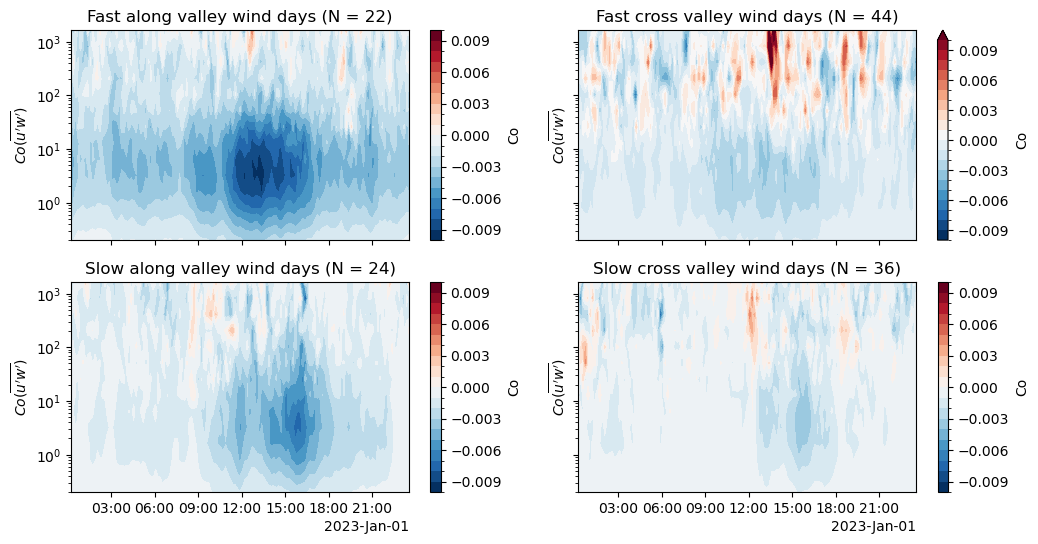

In [112]:
fig, axes = plt.subplots(2,2, figsize=(12,6), sharex=True, sharey=True)
LIM = 0.01
# fast_along_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    fast_along_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[0,0])
axes[0,0].set_title(f'Fast along valley wind days (N = {len(fast_along_valley_wind_days)})')

# fast_cross_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    fast_cross_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[0,1])
axes[0,1].set_title(f'Fast cross valley wind days (N = {len(fast_cross_valley_wind_days)})')

# slow_along_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    slow_along_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[1,0])
axes[1,0].set_title(f'Slow along valley wind days (N = {len(slow_along_valley_wind_days)})')

# slow_cross_valley_wind_days
ds_daily_avg = daily_mrds_df[daily_mrds_df.date.isin(
    slow_cross_valley_wind_days
)].groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau']
)[['Co']].mean().reset_index().set_index(['midpoint_time_nodate', 'tau']).to_xarray()
ds_daily_avg['Co'].plot.contourf(x='midpoint_time_nodate', y='tau', cmap='RdBu_r', levels=21, vmin=-LIM, vmax=LIM, ax=axes[1,1])
axes[1,1].set_title(f'Slow cross valley wind days (N = {len(slow_cross_valley_wind_days)})')


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel(r"$Co(\overline{u'w'})$")

In [126]:
src = pd.concat([
    daily_mrds_df[daily_mrds_df.date.isin(fast_along_valley_wind_days)].assign(category='fast_along'),
    daily_mrds_df[daily_mrds_df.date.isin(fast_cross_valley_wind_days)].assign(category='fast_cross'),
    # daily_mrds_df[daily_mrds_df.date.isin(slow_along_valley_wind_days)].assign(category='slow_along'),
    # daily_mrds_df[daily_mrds_df.date.isin(slow_cross_valley_wind_days)].assign(category='slow_cross'),
])
src = src[src.start_time.dt.hour >= 12]
src = src[src.start_time.dt.hour < 15]
src = src.groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau', 'category']
)[['Co']].mean().reset_index()

horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

uw_mrd_comparison = (
    horizontal_line + alt.Chart(
        src.reset_index()
    ).mark_boxplot(
        opacity=0.5
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('category:N')
    )
)

In [127]:
daily_mrds_uv_df['date'] = daily_mrds_uv_df['start_time'].dt.date
daily_mrds_uv_df['start_time_nodate'] = daily_mrds_uv_df['start_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_uv_df['end_time_nodate'] = daily_mrds_uv_df['end_time'].apply(lambda dt: dt.replace(year=2023, month=1, day=1))
daily_mrds_uv_df['midpoint_time_nodate'] = daily_mrds_uv_df['start_time_nodate'] + (daily_mrds_uv_df['end_time_nodate'] - daily_mrds_uv_df['start_time_nodate']) / 2

src = pd.concat([
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_along_valley_wind_days)].assign(category='fast_along'),
    daily_mrds_uv_df[daily_mrds_uv_df.date.isin(fast_cross_valley_wind_days)].assign(category='fast_cross'),
    # daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_along_valley_wind_days)].assign(category='slow_along'),
    # daily_mrds_uv_df[daily_mrds_uv_df.date.isin(slow_cross_valley_wind_days)].assign(category='slow_cross'),
])
src = src[src.start_time.dt.hour >= 12]
src = src[src.start_time.dt.hour < 15]
src = src.groupby(
    ['start_time_nodate', 'end_time_nodate', 'midpoint_time_nodate', 'tau', 'category']
)[['Co']].mean().reset_index()

horizontal_line = alt.Chart().mark_rule(color='red').encode(y=alt.datum(0))

uv_mrd_comparison = (
    horizontal_line + alt.Chart(
        src.reset_index()
    ).mark_boxplot(
        opacity=0.5
    ).encode(
        alt.X('tau:Q').scale(type='log'),
        alt.Y('Co:Q'),
        alt.Color('category:N')
    )
)

In [128]:
(uw_mrd_comparison | uv_mrd_comparison).configure_axis(grid=False)

alt.HConcatChart(...)

In [ ]:
wind_speed_src = sos_df.query("variable == 'spd_3m_c'")
wind_speed_src.head()

,time,variable,value,height,tower,measurement
1951488,2022-11-01 00:00:00,spd_3m_c,2.996172,3.0,c,wind speed
1951489,2022-11-01 00:30:00,spd_3m_c,2.772876,3.0,c,wind speed
1951490,2022-11-01 01:00:00,spd_3m_c,2.766295,3.0,c,wind speed
1951491,2022-11-01 01:30:00,spd_3m_c,2.972261,3.0,c,wind speed
1951492,2022-11-01 02:00:00,spd_3m_c,2.416516,3.0,c,wind speed


In [ ]:
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_along_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_cross_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_along_valley_wind_days)].value.mean())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_cross_valley_wind_days)].value.mean())

3.8115373240840253
2.8094820745825544
2.9109088878787084
2.4281729391506213


In [ ]:
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_along_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(fast_cross_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_along_valley_wind_days)].value.median())
print(wind_speed_src[wind_speed_src.time.dt.date.isin(slow_cross_valley_wind_days)].value.median())

3.6325018405914307
2.62816059589386
2.387258291244507
2.2239835262298584
